In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib

In [2]:
df = pd.read_csv('Events.csv')

In [3]:
df = df[(df['chi2']!=0)]

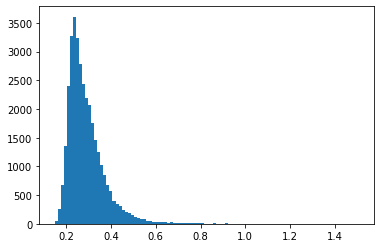

In [4]:
plt.hist(df['chi2'],bins=100)
plt.show()

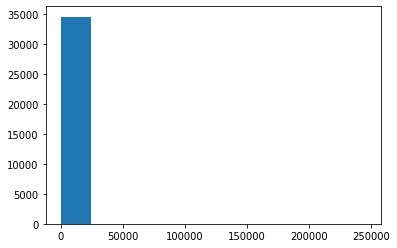

In [5]:
plt.hist(df['sigmat0'])
plt.show()

In [6]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x',
       'Laputop_pos_y'],
      dtype='object')

In [7]:
r = ((df['x'].values-df['ShowerCOG_x'].values)**2.0 + (df['y'].values-df['ShowerCOG_y'].values)**2.0 + (df['z'].values-df['ShowerCOG_z'].values)**2.0)**0.5

In [8]:
for i in range(len(r)):
    if df['ShowerCOG_time'].values[i] < df['t0'].values[i]:
        r[i] = r[i]
    else:
        r[i] = -r[i]

In [9]:
df['r'] = r

In [10]:
c = .299

In [11]:
def get_delta(r,a):
    delta = a * r**2.0 #+ b * (1-np.exp(-(r**2.0)/(2*sigma**2.0)))
    return delta

In [12]:
def get_n(x,y,z):
    x,y,z = np.array([x,y,z])/(x**2.0+y**2.0+z**2.0)**0.5
    return [x,y,z]

In [13]:
def get_n_cos(zen,az):
    x = -np.sin(zen) * np.cos(az)
    y = -np.sin(zen) * np.sin(az)
    z = -np.cos(zen)
    return x,y,z

In [14]:
def get_t(X,x1,y1,z1,a,xc,yc,zc,tc):
    x,y,z,r = X
    n = get_n(x1,y1,z1)
    x_new = np.array([(i-xc)*n[0] for i in x])
    y_new = np.array([(i-yc)*n[1] for i in y])
    z_new = np.array([(i-zc)*n[2] for i in z])
    new = x_new + y_new + z_new
    tc = np.array([tc for i in range(len(z_new))])
    t = tc + (1/c)*new + get_delta(r,a)
    return t

In [15]:
def get_ang_diff(x1,y1,z1,x2,y2,z2):
    n1 = np.array(get_n(x1,y1,z1))
    n2 = np.array(get_n(x2,y2,z2))
    if np.dot(n1,n2)>1:
        value = 1
        angular_diff = np.arccos(value)*180/np.pi
    else:
        angular_diff = np.arccos(np.dot(n1,n2))*180/np.pi
    return angular_diff

In [16]:
def ldf(r,S125,beta):
    k = 0.30264
    VEM = S125*(r/125)**(-beta-k*np.log10(r/125))
    return VEM

In [17]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')

In [18]:
def clean(event1):
    doms = []
    strings = []
    chi2 = []
    chargeVEM = []
    remove_index_list = []
    for value in range(len(event1)):
        doms.append(event1['Unnamed: 1'].values[value].split(',')[1])
        strings.append(event1['Unnamed: 1'].values[value].split(',')[0].split('(')[1])
        chi2.append(event1['chi2'].values[value])
        chargeVEM.append(event1['r'].values[value])
    doms = np.array(doms)
    strings = np.array(strings)
    chi2 = np.array(chi2)
    chargeVEM = np.array(chargeVEM)
    
    check = []
    
    for string in np.unique(strings):
        if np.sum(strings==string)==2:
            index_max = np.argmax(chi2[strings==string])
            if index_max == 0:
                check.append(False)
            else:
                check.append(True)
            if check[-1]:
                check.append(False)
            else:
                check.append(True)
        else:
            check.append(True)
            
    for i in range(len(check)):
        cutoff = np.mean(chi2[check])+2*np.mean(chi2[check])/len(chi2[check])
        if (chi2[i]>=cutoff):
            check[i] = False
    
    for i in range(len(check)):
        if not check[i]:
            remove_index_list.append(i)
    return remove_index_list,check

In [19]:
from scipy.optimize import curve_fit

In [20]:
from functools import partial

In [21]:
from random import choice

In [22]:
events = df['Unnamed: 0'].unique()

In [23]:
laputop_zenith = []
laputop_azimuth = []
mc_zenith = []
mc_azimuth = []
angular_resolution = []
for event in events:
    event1 = df.loc[df['Unnamed: 0'] == event]
    laputop_zenith.append(event1['Laputop_dir_zenith'].values[0])
    laputop_azimuth.append(event1['Laputop_dir_azimuth'].values[0])
    mc_zenith.append(event1['zenith'].values[0])
    mc_azimuth.append(event1['azimuth'].values[0])
    angular_resolution.append(event1['angular_resolution'].values[0])

In [109]:
ang_res = []
laputop_res = []
residuals = []
energy = []
zenith = []

def get_fit(event):
    event1 = df.loc[df['Unnamed: 0'] == event]
    event1 = event1.loc[abs(event1['r'])>50]
    
    energy = event1['energy'].values[0]
    zenith = event1['zenith'].values[0]
    true_zen = event1['zenith'].values[0]
    true_az = event1['azimuth'].values[0]
    
    true_x,true_y,true_z = get_n_cos(true_zen,true_az)

    tc = event1['ShowerCOG_time'].values[0]
    xc = event1['ShowerCOG_x'].values[0]
    yc = event1['ShowerCOG_y'].values[0]
    zc = event1['ShowerCOG_z'].values[0]
    zen_shower = event1['ShowerCOG_zen'].values[0]
    az_shower = event1['ShowerCOG_az'].values[0]
    
    x_start,y_start,z_start = get_n_cos(zen_shower,az_shower)
    a_start = 4.823*10**-4
    
    x_o = event1['x'].values
    y_o = event1['y'].values
    z_o = event1['z'].values
    r_o = event1['r'].values
    t0_o = event1['t0'].values
    
    get_t_new = partial(get_t,tc=tc,xc=xc,yc=yc,zc=zc)
    
    if len(event1)<20:
        remove_index_list = []
        check = [True for i in range(len(event1))]
    else:
        remove_index_list,check = clean(event1)
    fit_original = curve_fit(get_t_new,(x_o[check],y_o[check],z_o[check],r_o[check]),t0_o[check],
                    p0=[x_start,y_start,z_start,a_start],
                    bounds=((-1,-1,-1,0),(1,1,0,1e-3)),
                    maxfev=3000,
                    absolute_sigma=True)
    
    fit_old = curve_fit(get_t_new,(x_o,y_o,z_o,r_o),t0_o,
                    p0=[x_start,y_start,z_start,a_start],
                    bounds=((-1,-1,-1,0),(1,1,0,1e-3)),
                    maxfev=3000,
                    absolute_sigma=True)
    
    ang_diff_fit_o = get_ang_diff(fit_original[0][0],fit_original[0][1],fit_original[0][2],true_x,true_y,true_z)

    fit_list = []
    fit_list.append(fit_original)
    
    ang_res_list = []
    ang_res_list.append(ang_diff_fit_o)
    
    var_list = [np.inf]
    ang_diff_test = [np.inf]
    
    pass_value = False

    count = 0
    
    while True:
        if count == 0:
            check1 = np.copy(check)
        else:
            check1[remove_index] = False

        ang_list_test = []
        fit_check = []
        removed = []
        
        for i in np.array(range(len(check1))):
            check2 = np.copy(check1)
            check2[i] = False
            
            if i in remove_index_list:
                continue

            x = event1['x'].values[check2]
            y = event1['y'].values[check2]
            z = event1['z'].values[check2]
            r = event1['r'].values[check2]
            t0 = event1['t0'].values[check2]
    
            try:
                fit = curve_fit(get_t_new,(x,y,z,r),t0,
                            p0=[fit_list[-1][0][0],fit_list[-1][0][1],fit_list[-1][0][2],fit_list[-1][0][3]],
                            bounds=((-1,-1,-1,0),(1,1,0,1e-3)),
                            maxfev=3000,
                            absolute_sigma=True)
            except RuntimeError:
                pass_value = True
                break
            
            ang_diff_new = get_ang_diff(fit[0][0],fit[0][1],fit[0][2],fit_list[-1][0][0],fit_list[-1][0][1],fit_list[-1][0][2])
            chi2_penalty = event1['chi2'].values[i]
            ang_list_test.append(ang_diff_new*chi2_penalty)
            fit_check.append(fit)
            removed.append(i)
        
        if not pass_value:
            mean = np.mean(ang_list_test)
            var = ((len(ang_list_test)-1)/len(ang_list_test))*np.sum([(i-mean)**2.0 for i in ang_list_test])
            
            remove_index = removed[np.argmax(ang_list_test)]
            remove_index_list.append(remove_index)
            check1[remove_index]=False
        
            fit_new = fit_check[np.argmax(ang_list_test)]
            fit_list.append(fit_new)

            ang_diff_check = get_ang_diff(fit_new[0][0],fit_new[0][1],fit_new[0][2],fit_list[-2][0][0],fit_list[-2][0][1],fit_list[-2][0][2])
            ang_diff_true = get_ang_diff(fit_new[0][0],fit_new[0][1],fit_new[0][2],true_x,true_y,true_z)
        
            ang_res_list.append(ang_diff_true)
            var_list.append(var)
            ang_diff_test.append(ang_diff_check)
        
            if (np.sum(check1)<=3):
                ang_diff_final=ang_res_list[np.argmin(var_list)]
                var = var_list[np.argmin(var_list)]
                ang_test = var_list[np.argmin(var_list)]
                check1[remove_index]==True
                break
        else:
            ang_diff_final = ang_res_list[np.argmin(var_list)]
            var = var_list[np.argmin(var_list)]
            break

        count+=1  
        
    return event,ang_diff_final,len(event1),var
        
    

In [110]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 1', 'run_number', 'event_number', 'zenith',
       'azimuth', 'energy', 'x', 'y', 'z', 'ShowerCOG_x', 'ShowerCOG_y',
       'ShowerCOG_z', 'ShowerCOG_time', 'ShowerCOG_zen', 'ShowerCOG_az', 'm',
       's', 't0', 'charge', 'chargePe', 'chargeVEM', 'chi2', 'sigmat0',
       'sigmam', 'sigmas', 'feimpedance', 'spemean', 'pe_per_vem',
       'angular_resolution', 'chi2_ldf', 'chi2_time', 'Laputop_dir_zenith',
       'Laputop_dir_azimuth', 'Laputop_time', 'Laputop_pos_x', 'Laputop_pos_y',
       'r'],
      dtype='object')

In [111]:
import time

In [113]:
our_dict = {}
count = 0
for event in [events[0]]:
    if count == 100:
        print(count)
        count = 0
    time1 = time.time()
    value,ang_res_overall,length,var = get_fit(event)
    our_dict[value] = {}
    our_dict[value]['new'] = ang_res_overall
    our_dict[value]['length'] = length
    our_dict[value]['var'] = var
    print(ang_res_overall)
    
    time2 = time.time()
    count+=1

0.10674687717852432


In [39]:
res = []
length = []
var = []
for i in our_dict.keys():
    event1 = df.loc[df['Unnamed: 0'] == i]
    res.append(our_dict[i]['new'])
    length.append(our_dict[i]['length'])
    var.append(our_dict[i]['var'])
res = np.array(res)
length = np.array(length)
var = np.array(var)

In [40]:
import seaborn as sns

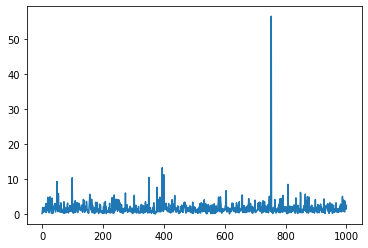

In [41]:
plt.plot(res)
plt.show()

In [42]:
events[np.argmax(res)]

'event_753'

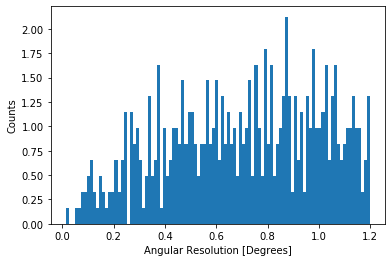

In [43]:
hist = plt.hist(res[res<1.2],bins=100,density=True)
plt.xlabel('Angular Resolution [Degrees]')
plt.ylabel('Counts')
plt.show()

In [44]:
#np.save('Model1',our_dict)

In [45]:
def Rayleigh(x,sigma):
    y = (x/sigma**2.0)*np.exp(-(x**2.0)/(2*sigma**2.0))
    return y

In [46]:
from math import gamma

In [47]:
def chi2(x,k):
    chi2 = (1/((2**(k/2))*gamma(k/2)))*(x**(k/2-1))*np.exp(-x/2)
    return chi2

In [48]:
fit = curve_fit(Rayleigh,hist[0],hist[1][0:-1])

In [49]:
fit2 = curve_fit(chi2,hist[0],hist[1][0:-1],p0=[3])

/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


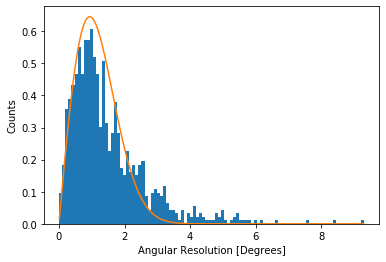

In [50]:
hist = plt.hist(res[res<10],bins=100,density=True)
x = np.linspace(min(hist[1]),max(hist[1]),1000)
y = Rayleigh(x,fit[0])
#y = chi2(x,fit2[0])
plt.plot(x,y)
plt.xlabel('Angular Resolution [Degrees]')
plt.ylabel('Counts')
plt.savefig('rayleigh_Angular_resolution')

In [51]:
fit

(array([0.93998122]), array([[0.00249009]]))

In [52]:
print('mean',fit[0][0]*(np.pi/2)**0.5)
print('median',fit[0][0]*(-2*np.log(1-0.5))**0.5)
print('95%',fit[0][0]*(-2*np.log(1-0.95))**0.5)
print('mode',fit[0][0])
print('variance',((4-np.pi)/2)*fit[0][0]**2.0)

mean 1.178091747305913
median 1.1067433051475843
95% 2.3008360433050465
mode 0.9399812163846587
variance 0.3792292092416658
